### Import

In [25]:
import pandas as pd
import numpy as np
import gc
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import os

### Data Load

In [ ]:
data_splits = ["train", "test"]

base_path = 'open 2'

data_categories = {
    "회원정보": {"folder": "1.회원정보", "suffix": "회원정보", "var_prefix": "customer"},
    "신용정보": {"folder": "2.신용정보", "suffix": "신용정보", "var_prefix": "credit"},
    "승인매출정보": {"folder": "3.승인매출정보", "suffix": "승인매출정보", "var_prefix": "sales"},
    "청구정보": {"folder": "4.청구입금정보", "suffix": "청구정보", "var_prefix": "billing"},
    "잔액정보": {"folder": "5.잔액정보", "suffix": "잔액정보", "var_prefix": "balance"},
    "채널정보": {"folder": "6.채널정보", "suffix": "채널정보", "var_prefix": "channel"},
    "마케팅정보": {"folder": "7.마케팅정보", "suffix": "마케팅정보", "var_prefix": "marketing"},
    "성과정보": {"folder": "8.성과정보", "suffix": "성과정보", "var_prefix": "performance"}
}

months = ['07', '08', '09','10','11','12']

for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]
        
        for month in months:
            # 파일명 형식: 2018{month}_{split}_{suffix}.parquet
            file_path = os.path.join(base_path, split, folder, f"2018{month}_{split}_{suffix}.parquet")
            # 변수명 형식: {var_prefix}_{split}_{month}
            variable_name = f"{var_prefix}_{split}_{month}"
            globals()[variable_name] = pd.read_parquet(file_path)
            print(f"{variable_name} is loaded from {file_path}")

gc.collect()

### Data Preprocessing(1) : Concat & Merge

In [ ]:
info_categories = ["customer", "credit", "sales", "billing", "balance", "channel", "marketing", "performance"]

months = ['07','08','09','10','11','12']

In [28]:
#### Train ####

# 각 유형별로 월별 데이터를 합쳐서 새로운 변수에 저장
train_dfs = {}

for prefix in info_categories:
    # globals()에서 동적 변수명으로 데이터프레임들을 가져와 리스트에 저장
    df_list = [globals()[f"{prefix}_train_{month}"] for month in months]
    train_dfs[f"{prefix}_train_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_train_df is created with shape: {train_dfs[f'{prefix}_train_df'].shape}")


customer_train_df = train_dfs["customer_train_df"]
credit_train_df   = train_dfs["credit_train_df"]
sales_train_df    = train_dfs["sales_train_df"]
billing_train_df  = train_dfs["billing_train_df"]
balance_train_df  = train_dfs["balance_train_df"]
channel_train_df  = train_dfs["channel_train_df"]
marketing_train_df= train_dfs["marketing_train_df"]
performance_train_df = train_dfs["performance_train_df"]

gc.collect()

customer_train_df is created with shape: (2400000, 78)
credit_train_df is created with shape: (2400000, 42)
sales_train_df is created with shape: (2400000, 406)
billing_train_df is created with shape: (2400000, 46)
balance_train_df is created with shape: (2400000, 82)
channel_train_df is created with shape: (2400000, 105)
marketing_train_df is created with shape: (2400000, 64)
performance_train_df is created with shape: (2400000, 49)


0

In [5]:
customer_segment = customer_train_df[['기준년월', 'ID', 'Segment']].copy()

In [6]:
datasets = {
    'credit': credit_train_df,
    'sales': sales_train_df,
    'billing': billing_train_df,
    'balance': balance_train_df,
    'channel': channel_train_df,
    'marketing': marketing_train_df,
    'performance': performance_train_df
}

In [8]:
merged_datasets = {}
for name, df in datasets.items():
    merged = df.merge(customer_segment, on=['기준년월', 'ID'], how='left')
    merged_datasets[name] = merged
    print(f"{name} 데이터에 segment merge 완료! shape: {merged.shape}")

credit 데이터에 segment merge 완료! shape: (2400000, 43)
sales 데이터에 segment merge 완료! shape: (2400000, 407)
billing 데이터에 segment merge 완료! shape: (2400000, 47)
balance 데이터에 segment merge 완료! shape: (2400000, 83)
channel 데이터에 segment merge 완료! shape: (2400000, 106)
marketing 데이터에 segment merge 완료! shape: (2400000, 65)
performance 데이터에 segment merge 완료! shape: (2400000, 50)


In [29]:
#### Test ####

# test 데이터에 대해 train과 동일한 방법 적용
test_dfs = {}

for prefix in info_categories:
    df_list = [globals()[f"{prefix}_test_{month}"] for month in months]
    test_dfs[f"{prefix}_test_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_test_df is created with shape: {test_dfs[f'{prefix}_test_df'].shape}")


customer_test_df = test_dfs["customer_test_df"]
credit_test_df   = test_dfs["credit_test_df"]
sales_test_df    = test_dfs["sales_test_df"]
billing_test_df  = test_dfs["billing_test_df"]
balance_test_df  = test_dfs["balance_test_df"]
channel_test_df  = test_dfs["channel_test_df"]
marketing_test_df= test_dfs["marketing_test_df"]
performance_test_df = test_dfs["performance_test_df"]

gc.collect()

customer_test_df is created with shape: (600000, 77)
credit_test_df is created with shape: (600000, 42)
sales_test_df is created with shape: (600000, 406)
billing_test_df is created with shape: (600000, 46)
balance_test_df is created with shape: (600000, 82)
channel_test_df is created with shape: (600000, 105)
marketing_test_df is created with shape: (600000, 64)
performance_test_df is created with shape: (600000, 49)


0

In [ ]:
#### Train ####

train_df = customer_train_df.merge(credit_train_df, on=['기준년월', 'ID'], how='left')
print("Step1 저장 완료: train_step1, shape:", train_df.shape)
del customer_train_df, credit_train_df
gc.collect()

# 이후 merge할 데이터프레임 이름과 단계 정보를 리스트에 저장
merge_list = [
    ("sales_train_df",    "Step2"),
    ("billing_train_df",  "Step3"),
    ("balance_train_df",  "Step4"),
    ("channel_train_df",  "Step5"),
    ("marketing_train_df","Step6"),
    ("performance_train_df", "최종")
]

# 나머지 단계 merge
for df_name, step in merge_list:
    # globals()로 동적 변수 접근하여 merge 수행
    train_df = train_df.merge(globals()[df_name], on=['기준년월', 'ID'], how='left')
    print(f"{step} 저장 완료: train_{step}, shape:", train_df.shape)
    # 사용한 변수는 메모리 해제를 위해 삭제
    del globals()[df_name]
    gc.collect()

In [9]:
#### Test ####

test_df = customer_test_df.merge(credit_test_df, on=['기준년월', 'ID'], how='left')
print("Step1 저장 완료: test_step1, shape:", test_df.shape)
del customer_test_df, credit_test_df
gc.collect()

# 이후 merge할 데이터프레임 이름과 단계 정보를 리스트에 저장
merge_list = [
    ("sales_test_df",    "Step2"),
    ("billing_test_df",  "Step3"),
    ("balance_test_df",  "Step4"),
    ("channel_test_df",  "Step5"),
    ("marketing_test_df","Step6"),
    ("performance_test_df", "최종")
]

# 나머지 단계 merge
for df_name, step in merge_list:
    # globals()로 동적 변수 접근하여 merge 수행
    test_df = test_df.merge(globals()[df_name], on=['기준년월', 'ID'], how='left')
    print(f"{step} 저장 완료: test_{step}, shape:", test_df.shape)
    # 사용한 변수는 메모리 해제를 위해 삭제
    del globals()[df_name]
    gc.collect()

Step1 저장 완료: test_step1, shape: (600000, 117)
Step2 저장 완료: test_Step2, shape: (600000, 521)
Step3 저장 완료: test_Step3, shape: (600000, 565)
Step4 저장 완료: test_Step4, shape: (600000, 645)
Step5 저장 완료: test_Step5, shape: (600000, 748)
Step6 저장 완료: test_Step6, shape: (600000, 810)
최종 저장 완료: test_최종, shape: (600000, 857)


### train 시각화를 통한 변수 선택

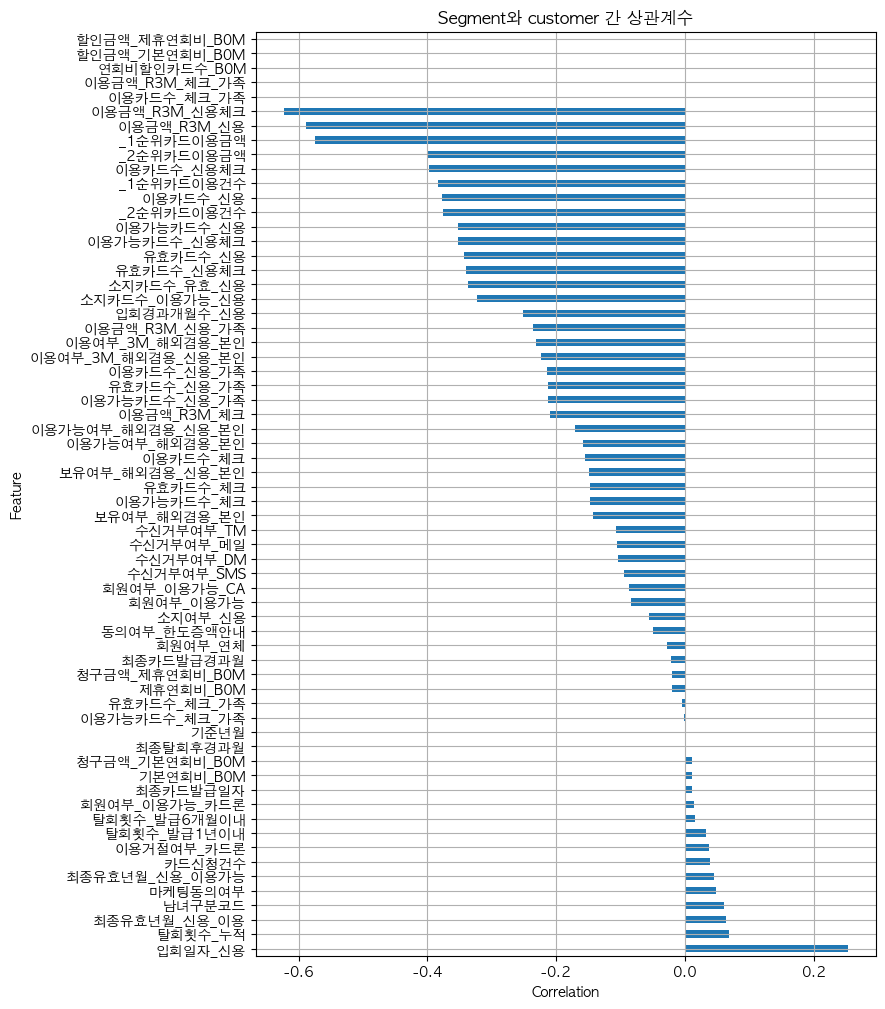

In [17]:
#### customer
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

mpl.rc('font', family='AppleGothic')
mpl.rc('axes', unicode_minus=False)

encoded = customer_train_df.copy()
le = LabelEncoder()
encoded['Segment_encoded'] = le.fit_transform(encoded['Segment'])

# 숫자형 컬럼 + Segment_encoded 만 골라서
numeric_cols = encoded.select_dtypes(include=[np.number])

# 상관계수 계산
plt.figure(figsize=(14, 12))
corr = numeric_cols.corr()

# Segment_encoded랑 다른 변수들 사이의 상관관계
target_corr = corr['Segment_encoded'].drop('Segment_encoded')

# 막대그래프
target_corr.sort_values(ascending=False).plot(kind='barh', figsize=(8, 12))
plt.title("Segment와 customer 간 상관계수")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.grid()
plt.show()

In [18]:
### 절댓값이 0.2 이상인 것 
important_features = target_corr[abs(target_corr) >= 0.2]

# 변수 이름 출력
print("상관계수 절댓값이 0.2 이상인 변수들:")
print(important_features.index.tolist())

상관계수 절댓값이 0.2 이상인 변수들:
['소지카드수_유효_신용', '소지카드수_이용가능_신용', '입회일자_신용', '입회경과개월수_신용', '유효카드수_신용체크', '유효카드수_신용', '유효카드수_신용_가족', '이용가능카드수_신용체크', '이용가능카드수_신용', '이용가능카드수_신용_가족', '이용카드수_신용체크', '이용카드수_신용', '이용카드수_신용_가족', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '이용금액_R3M_신용_가족', '이용금액_R3M_체크', '_1순위카드이용금액', '_1순위카드이용건수', '_2순위카드이용금액', '_2순위카드이용건수', '이용여부_3M_해외겸용_본인', '이용여부_3M_해외겸용_신용_본인']


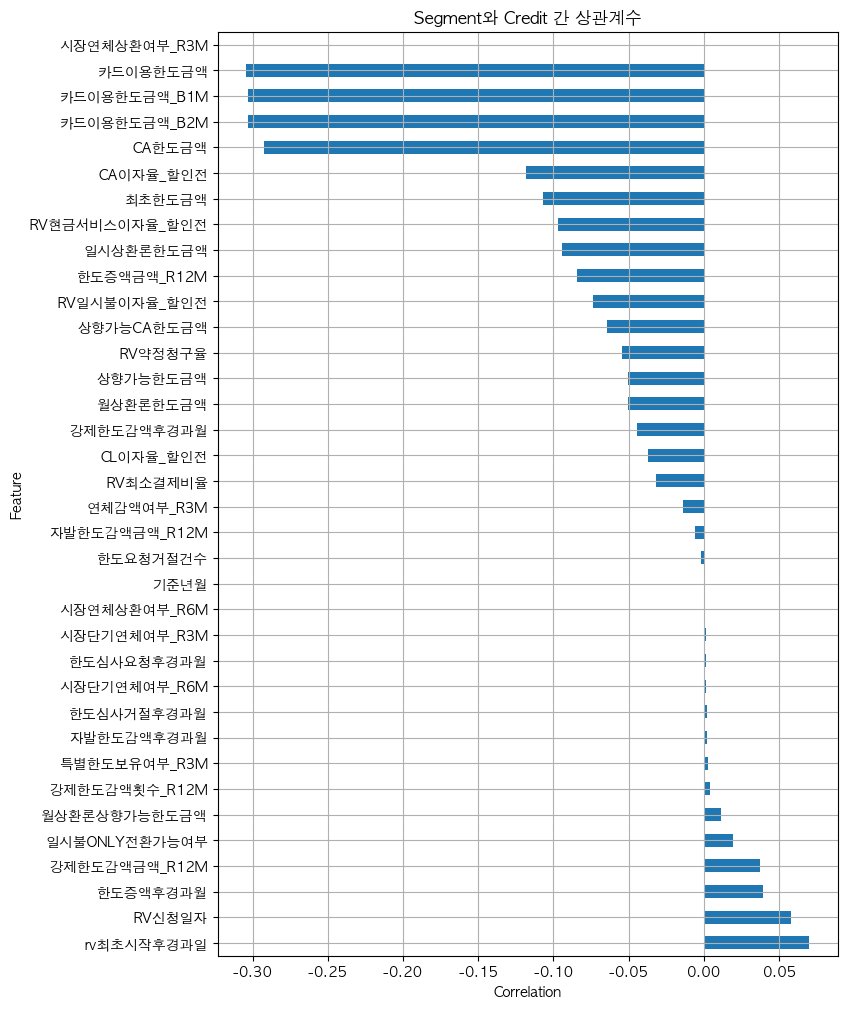

In [19]:
### credit
mpl.rc('font', family='AppleGothic')
mpl.rc('axes', unicode_minus=False)

encoded = merged_datasets['credit'].copy()
le = LabelEncoder()
encoded['Segment_encoded'] = le.fit_transform(encoded['Segment'])

# 숫자형 컬럼 + Segment_encoded 만 골라서
numeric_cols = encoded.select_dtypes(include=[np.number])

# 상관계수 계산
plt.figure(figsize=(14, 12))
corr = numeric_cols.corr()

# Segment_encoded랑 다른 변수들 사이의 상관관계
target_corr = corr['Segment_encoded'].drop('Segment_encoded')

# 막대그래프
target_corr.sort_values(ascending=False).plot(kind='barh', figsize=(8, 12))
plt.title("Segment와 Credit 간 상관계수")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.grid()
plt.show()

In [21]:
### 절댓값이 0.2 이상인 것 
important_features = target_corr[abs(target_corr) >= 0.2]

# 변수 이름 출력
print("상관계수 절댓값이 0.2 이상인 변수들:")
print(important_features.index.tolist())

상관계수 절댓값이 0.2 이상인 변수들:
['카드이용한도금액', 'CA한도금액', '카드이용한도금액_B1M', '카드이용한도금액_B2M']


In [15]:
# sales 데이터 준비
encoded = merged_datasets['sales'].copy()
le = LabelEncoder()
encoded['Segment_encoded'] = le.fit_transform(encoded['Segment'])

# 숫자형 컬럼 + Segment_encoded 만 고르기
numeric_cols = encoded.select_dtypes(include=[np.number])

# 상관계수 계산
corr = numeric_cols.corr()

# Segment_encoded와 다른 변수들 사이의 상관계수만 뽑기
target_corr = corr['Segment_encoded'].drop('Segment_encoded')

# 상관계수 수치 출력
print(target_corr.sort_values(ascending=False))

이용후경과월_할부_무이자      0.256619
이용후경과월_할부          0.251750
이용후경과월_CA          0.237314
이용후경과월_신용          0.204829
이용후경과월_신판          0.194259
                     ...   
이용금액_당사기타_B0M           NaN
이용건수_당사페이_B0M           NaN
이용건수_당사기타_B0M           NaN
승인거절건수_입력오류_B0M         NaN
승인거절건수_기타_B0M           NaN
Name: Segment_encoded, Length: 388, dtype: float64


In [16]:
### 절댓값이 0.2 이상인 것 
important_features = target_corr[abs(target_corr) >= 0.2]

# 변수 이름 출력
print("상관계수 절댓값이 0.2 이상인 변수들:")
print(important_features.index.tolist())

상관계수 절댓값이 0.2 이상인 변수들:
['최종이용일자_CA', '최종이용일자_할부', '이용건수_신용_B0M', '이용건수_신판_B0M', '이용건수_일시불_B0M', '이용건수_할부_B0M', '이용건수_할부_무이자_B0M', '이용건수_CA_B0M', '이용건수_체크_B0M', '이용금액_일시불_B0M', '이용금액_할부_B0M', '이용금액_할부_무이자_B0M', '이용금액_CA_B0M', '이용금액_체크_B0M', '이용후경과월_신용', '이용후경과월_할부', '이용후경과월_할부_무이자', '이용후경과월_CA', '이용건수_신용_R12M', '이용건수_신판_R12M', '이용건수_일시불_R12M', '이용건수_할부_R12M', '이용건수_할부_무이자_R12M', '이용건수_CA_R12M', '이용건수_체크_R12M', '이용금액_일시불_R12M', '이용금액_할부_R12M', '이용금액_할부_무이자_R12M', '이용금액_CA_R12M', '이용금액_체크_R12M', '최대이용금액_일시불_R12M', '최대이용금액_할부_R12M', '최대이용금액_할부_무이자_R12M', '최대이용금액_CA_R12M', '최대이용금액_체크_R12M', '이용개월수_신용_R12M', '이용개월수_신판_R12M', '이용개월수_일시불_R12M', '이용개월수_할부_R12M', '이용개월수_할부_무이자_R12M', '이용개월수_CA_R12M', '이용건수_신용_R6M', '이용건수_신판_R6M', '이용건수_일시불_R6M', '이용건수_할부_R6M', '이용건수_할부_무이자_R6M', '이용건수_CA_R6M', '이용건수_체크_R6M', '이용금액_일시불_R6M', '이용금액_할부_R6M', '이용금액_할부_무이자_R6M', '이용금액_CA_R6M', '이용금액_체크_R6M', '이용개월수_신용_R6M', '이용개월수_신판_R6M', '이용개월수_일시불_R6M', '이용개월수_할부_R6M', '이용개월수_할부_무이자_R6M', '이용개월수_CA_R6M', '이용건수_신용_

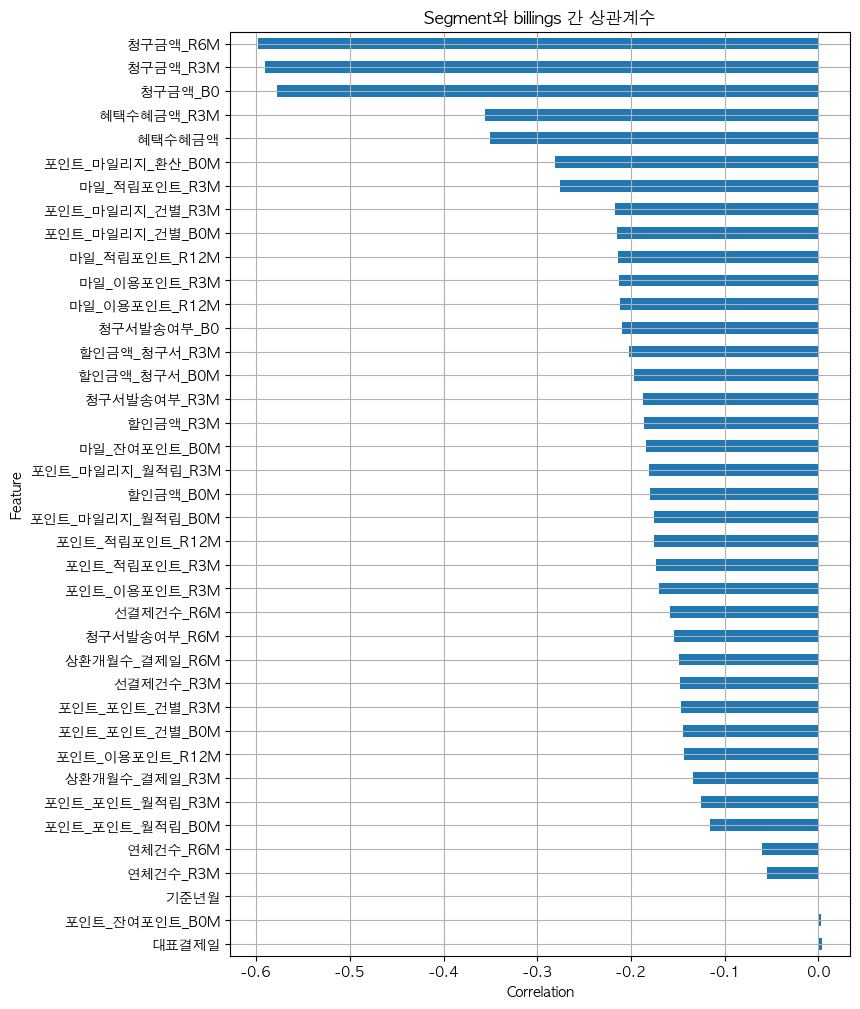

In [22]:
### billing
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

mpl.rc('font', family='AppleGothic')
mpl.rc('axes', unicode_minus=False)

encoded = merged_datasets['billing'].copy()
le = LabelEncoder()
encoded['Segment_encoded'] = le.fit_transform(encoded['Segment'])

# 숫자형 컬럼 + Segment_encoded 만 골라서
numeric_cols = encoded.select_dtypes(include=[np.number])

# 상관계수 계산
plt.figure(figsize=(14, 12))
corr = numeric_cols.corr()

# Segment_encoded랑 다른 변수들 사이의 상관관계
target_corr = corr['Segment_encoded'].drop('Segment_encoded')

# 막대그래프
target_corr.sort_values(ascending=False).plot(kind='barh', figsize=(8, 12))
plt.title("Segment와 billings 간 상관계수")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.grid()
plt.show()

In [23]:
### 절댓값이 0.2 이상인 것 
important_features = target_corr[abs(target_corr) >= 0.2]

# 변수 이름 출력
print("상관계수 절댓값이 0.2 이상인 변수들:")
print(important_features.index.tolist())

상관계수 절댓값이 0.2 이상인 변수들:
['청구서발송여부_B0', '청구금액_B0', '청구금액_R3M', '청구금액_R6M', '포인트_마일리지_건별_B0M', '포인트_마일리지_건별_R3M', '마일_적립포인트_R12M', '마일_적립포인트_R3M', '마일_이용포인트_R12M', '마일_이용포인트_R3M', '할인금액_청구서_R3M', '혜택수혜금액_R3M', '포인트_마일리지_환산_B0M', '혜택수혜금액']


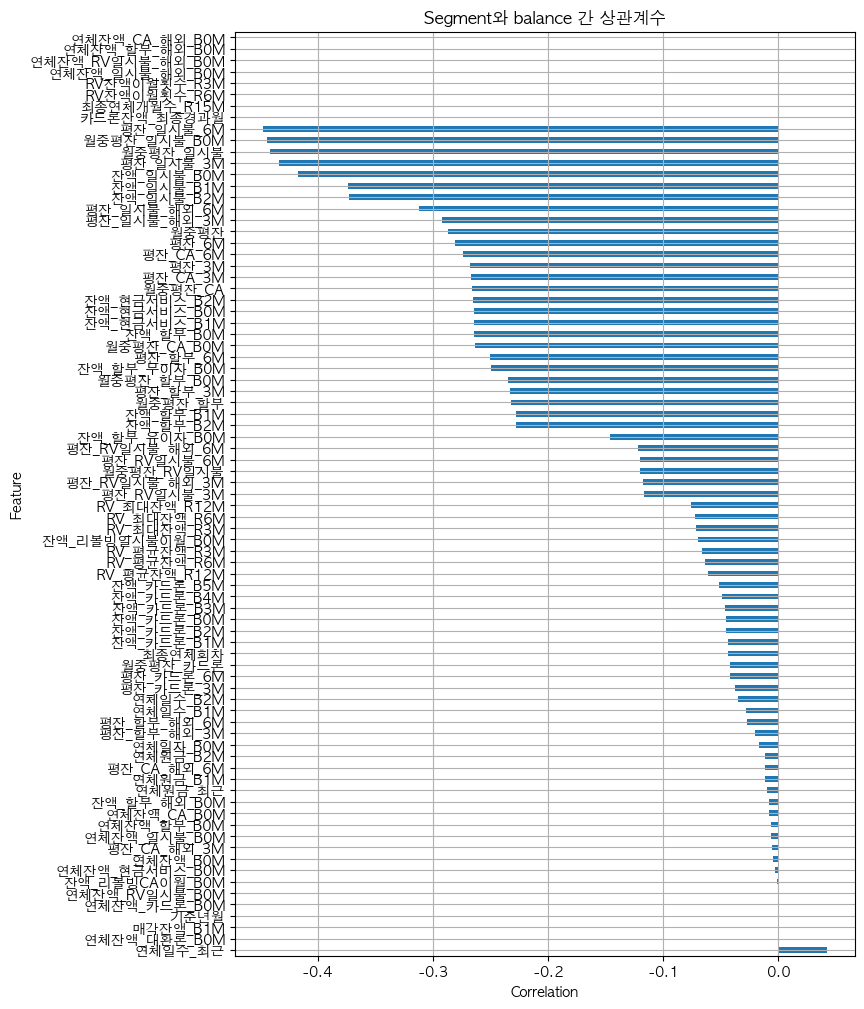

In [24]:
### balance

mpl.rc('font', family='AppleGothic')
mpl.rc('axes', unicode_minus=False)

encoded = merged_datasets['balance'].copy()
le = LabelEncoder()
encoded['Segment_encoded'] = le.fit_transform(encoded['Segment'])

# 숫자형 컬럼 + Segment_encoded 만 골라서
numeric_cols = encoded.select_dtypes(include=[np.number])

# 상관계수 계산
plt.figure(figsize=(14, 12))
corr = numeric_cols.corr()

# Segment_encoded랑 다른 변수들 사이의 상관관계
target_corr = corr['Segment_encoded'].drop('Segment_encoded')

# 막대그래프
target_corr.sort_values(ascending=False).plot(kind='barh', figsize=(8, 12))
plt.title("Segment와 balance 간 상관계수")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.grid()
plt.show()

In [25]:
### 절댓값이 0.2 이상인 것 
important_features = target_corr[abs(target_corr) >= 0.2]

# 변수 이름 출력
print("상관계수 절댓값이 0.2 이상인 변수들:")
print(important_features.index.tolist())

상관계수 절댓값이 0.2 이상인 변수들:
['잔액_일시불_B0M', '잔액_할부_B0M', '잔액_현금서비스_B0M', '월중평잔_일시불_B0M', '월중평잔_할부_B0M', '월중평잔_CA_B0M', '잔액_현금서비스_B1M', '잔액_현금서비스_B2M', '잔액_할부_B1M', '잔액_할부_B2M', '잔액_일시불_B1M', '잔액_일시불_B2M', '잔액_할부_무이자_B0M', '월중평잔', '월중평잔_일시불', '월중평잔_할부', '월중평잔_CA', '평잔_3M', '평잔_일시불_3M', '평잔_일시불_해외_3M', '평잔_할부_3M', '평잔_CA_3M', '평잔_6M', '평잔_일시불_6M', '평잔_일시불_해외_6M', '평잔_할부_6M', '평잔_CA_6M']


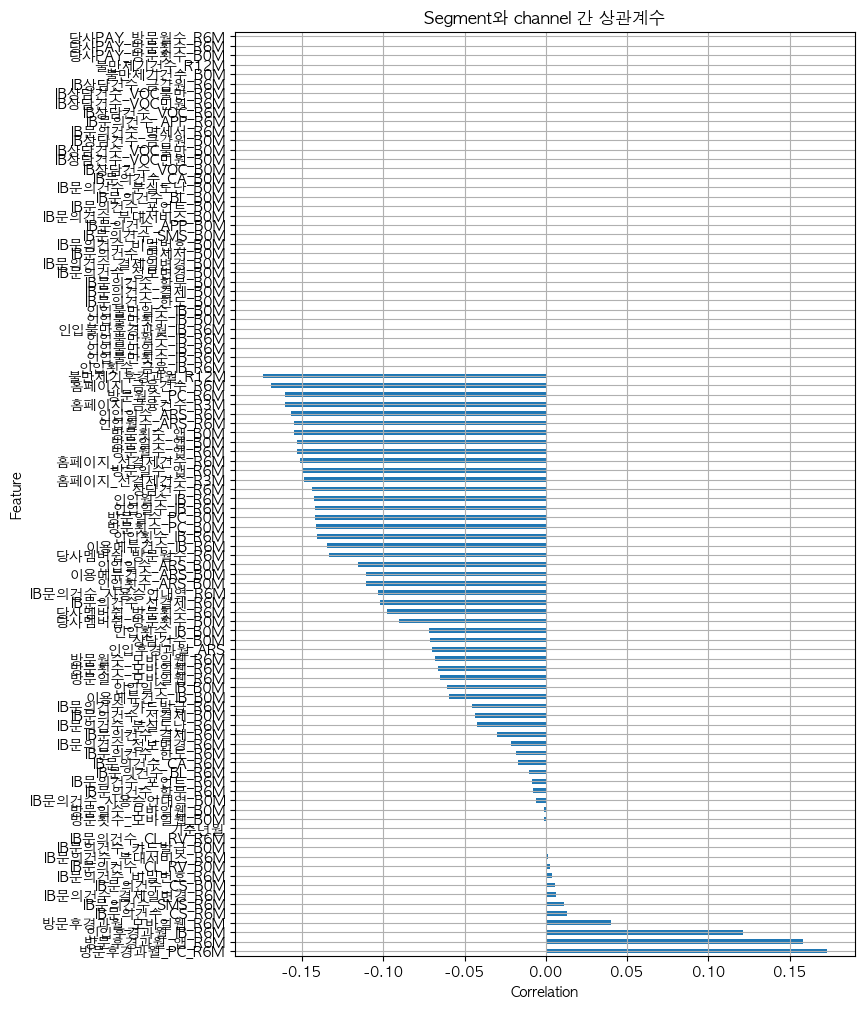

In [26]:
### channel
mpl.rc('font', family='AppleGothic')
mpl.rc('axes', unicode_minus=False)

encoded = merged_datasets['channel'].copy()
le = LabelEncoder()
encoded['Segment_encoded'] = le.fit_transform(encoded['Segment'])

# 숫자형 컬럼 + Segment_encoded 만 골라서
numeric_cols = encoded.select_dtypes(include=[np.number])

# 상관계수 계산
plt.figure(figsize=(14, 12))
corr = numeric_cols.corr()

# Segment_encoded랑 다른 변수들 사이의 상관관계
target_corr = corr['Segment_encoded'].drop('Segment_encoded')

# 막대그래프
target_corr.sort_values(ascending=False).plot(kind='barh', figsize=(8, 12))
plt.title("Segment와 channel 간 상관계수")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.grid()
plt.show()

In [27]:
### 절댓값이 0.2 이상인 것 
important_features = target_corr[abs(target_corr) >= 0.2]

# 변수 이름 출력
print("상관계수 절댓값이 0.2 이상인 변수들:")
print(important_features.index.tolist())

상관계수 절댓값이 0.2 이상인 변수들:
[]


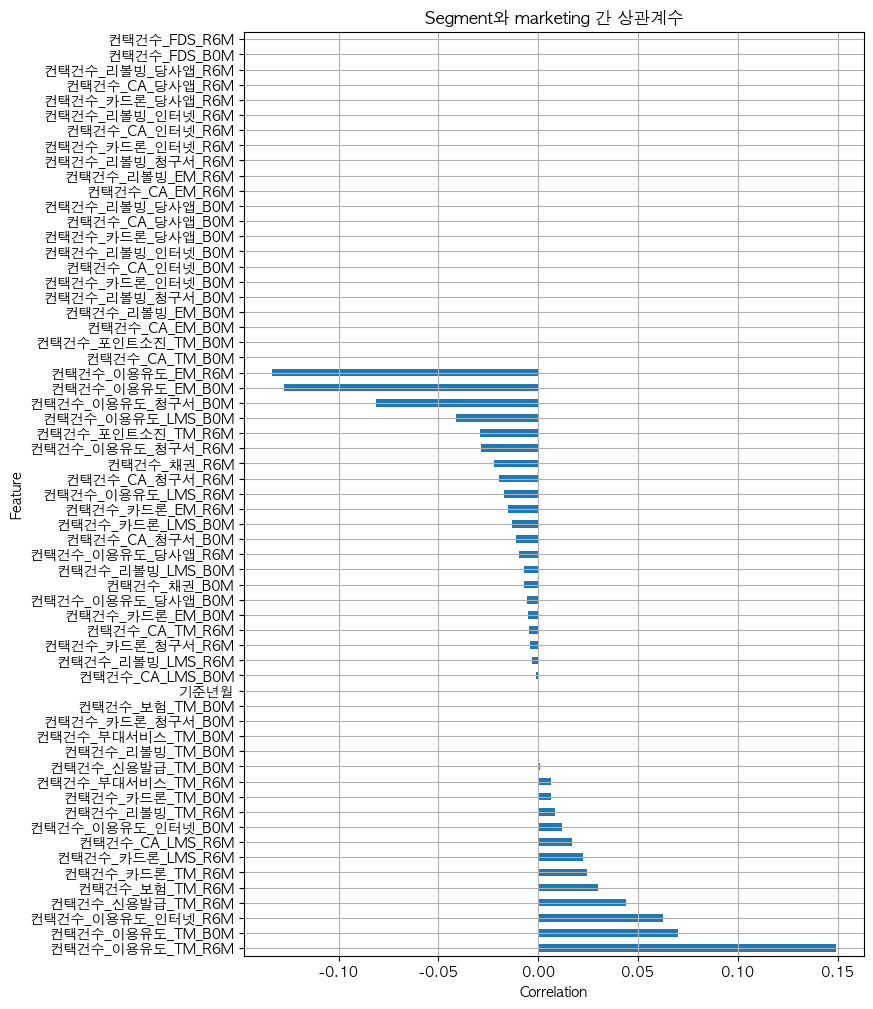

In [28]:
### marketing
mpl.rc('font', family='AppleGothic')
mpl.rc('axes', unicode_minus=False)

encoded = merged_datasets['marketing'].copy()
le = LabelEncoder()
encoded['Segment_encoded'] = le.fit_transform(encoded['Segment'])

# 숫자형 컬럼 + Segment_encoded 만 골라서
numeric_cols = encoded.select_dtypes(include=[np.number])

# 상관계수 계산
plt.figure(figsize=(14, 12))
corr = numeric_cols.corr()

# Segment_encoded랑 다른 변수들 사이의 상관관계
target_corr = corr['Segment_encoded'].drop('Segment_encoded')

# 막대그래프
target_corr.sort_values(ascending=False).plot(kind='barh', figsize=(8, 12))
plt.title("Segment와 marketing 간 상관계수")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.grid()
plt.show()

In [29]:
### 절댓값이 0.2 이상인 것 
important_features = target_corr[abs(target_corr) >= 0.2]

# 변수 이름 출력
print("상관계수 절댓값이 0.2 이상인 변수들:")
print(important_features.index.tolist())

상관계수 절댓값이 0.2 이상인 변수들:
[]


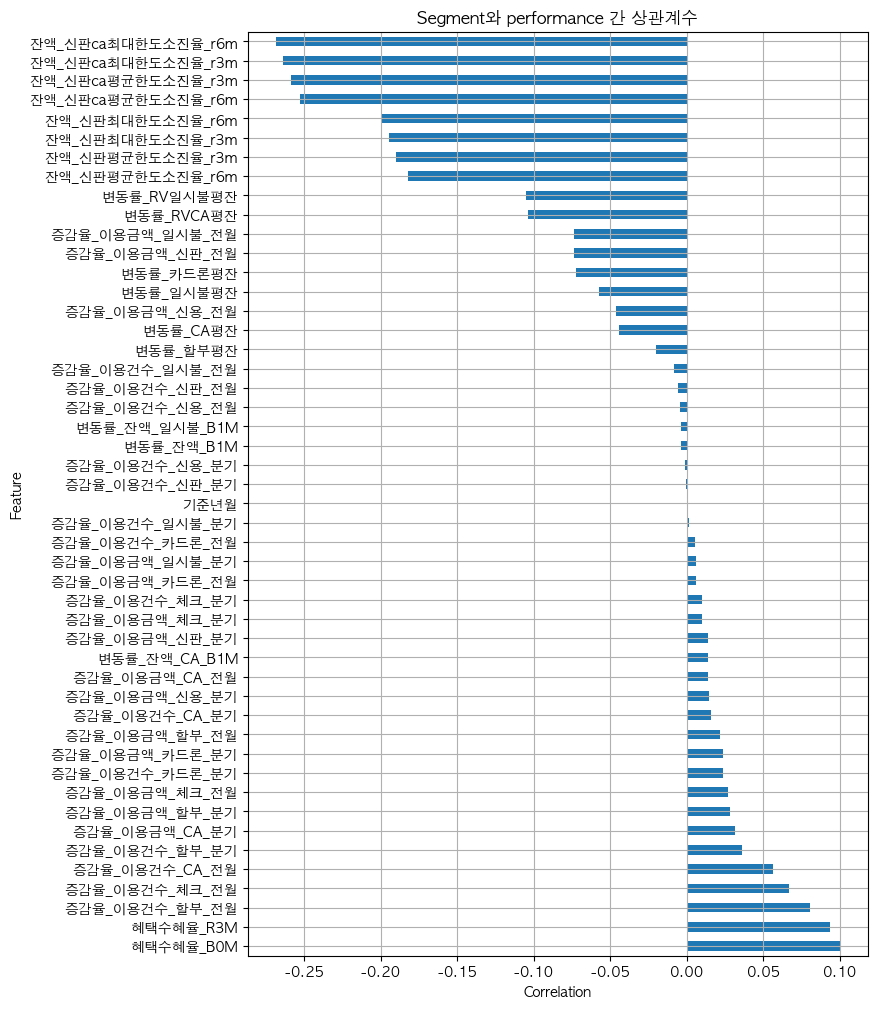

In [30]:
### performance
mpl.rc('font', family='AppleGothic')
mpl.rc('axes', unicode_minus=False)

encoded = merged_datasets['performance'].copy()
le = LabelEncoder()
encoded['Segment_encoded'] = le.fit_transform(encoded['Segment'])

# 숫자형 컬럼 + Segment_encoded 만 골라서
numeric_cols = encoded.select_dtypes(include=[np.number])

# 상관계수 계산
plt.figure(figsize=(14, 12))
corr = numeric_cols.corr()

# Segment_encoded랑 다른 변수들 사이의 상관관계
target_corr = corr['Segment_encoded'].drop('Segment_encoded')

# 막대그래프
target_corr.sort_values(ascending=False).plot(kind='barh', figsize=(8, 12))
plt.title("Segment와 performance 간 상관계수")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.grid()
plt.show()

In [31]:
### 절댓값이 0.2 이상인 것 
important_features = target_corr[abs(target_corr) >= 0.2]

# 변수 이름 출력
print("상관계수 절댓값이 0.2 이상인 변수들:")
print(important_features.index.tolist())

상관계수 절댓값이 0.2 이상인 변수들:
['잔액_신판최대한도소진율_r6m', '잔액_신판ca평균한도소진율_r6m', '잔액_신판ca최대한도소진율_r6m', '잔액_신판ca평균한도소진율_r3m', '잔액_신판ca최대한도소진율_r3m']


### Data Preprocessing(2) : Encoding

In [20]:
group = ['소지카드수_유효_신용', '소지카드수_이용가능_신용', '입회일자_신용', '입회경과개월수_신용', '유효카드수_신용체크', '유효카드수_신용', '유효카드수_신용_가족', '이용가능카드수_신용체크', '이용가능카드수_신용', '이용가능카드수_신용_가족', '이용카드수_신용체크', '이용카드수_신용', '이용카드수_신용_가족', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '이용금액_R3M_신용_가족', '이용금액_R3M_체크', '_1순위카드이용금액', '_1순위카드이용건수', '_2순위카드이용금액', '_2순위카드이용건수', '이용여부_3M_해외겸용_본인', '이용여부_3M_해외겸용_신용_본인','카드이용한도금액', 'CA한도금액', '카드이용한도금액_B1M', '카드이용한도금액_B2M','최종이용일자_CA', '최종이용일자_할부', '이용건수_신용_B0M', '이용건수_신판_B0M', '이용건수_일시불_B0M', '이용건수_할부_B0M', '이용건수_할부_무이자_B0M', '이용건수_CA_B0M', '이용건수_체크_B0M', '이용금액_일시불_B0M', '이용금액_할부_B0M', '이용금액_할부_무이자_B0M', '이용금액_CA_B0M', '이용금액_체크_B0M', '이용후경과월_신용', '이용후경과월_할부', '이용후경과월_할부_무이자', '이용후경과월_CA', '이용건수_신용_R12M', '이용건수_신판_R12M', '이용건수_일시불_R12M', '이용건수_할부_R12M', '이용건수_할부_무이자_R12M', '이용건수_CA_R12M', '이용건수_체크_R12M', '이용금액_일시불_R12M', '이용금액_할부_R12M', '이용금액_할부_무이자_R12M', '이용금액_CA_R12M', '이용금액_체크_R12M', '최대이용금액_일시불_R12M', '최대이용금액_할부_R12M', '최대이용금액_할부_무이자_R12M', '최대이용금액_CA_R12M', '최대이용금액_체크_R12M', '이용개월수_신용_R12M', '이용개월수_신판_R12M', '이용개월수_일시불_R12M', '이용개월수_할부_R12M', '이용개월수_할부_무이자_R12M', '이용개월수_CA_R12M', '이용건수_신용_R6M', '이용건수_신판_R6M', '이용건수_일시불_R6M', '이용건수_할부_R6M', '이용건수_할부_무이자_R6M', '이용건수_CA_R6M', '이용건수_체크_R6M', '이용금액_일시불_R6M', '이용금액_할부_R6M', '이용금액_할부_무이자_R6M', '이용금액_CA_R6M', '이용금액_체크_R6M', '이용개월수_신용_R6M', '이용개월수_신판_R6M', '이용개월수_일시불_R6M', '이용개월수_할부_R6M', '이용개월수_할부_무이자_R6M', '이용개월수_CA_R6M', '이용건수_신용_R3M', '이용건수_신판_R3M', '이용건수_일시불_R3M', '이용건수_할부_R3M', '이용건수_할부_무이자_R3M', '이용건수_CA_R3M', '이용건수_체크_R3M', '이용금액_일시불_R3M', '이용금액_할부_R3M', '이용금액_할부_무이자_R3M', '이용금액_CA_R3M', '이용금액_체크_R3M', '이용개월수_신용_R3M', '이용개월수_할부_R3M', '이용개월수_할부_무이자_R3M', '이용개월수_CA_R3M', '이용가맹점수', '이용금액_해외', '쇼핑_도소매_이용금액', '쇼핑_백화점_이용금액', '쇼핑_마트_이용금액', '쇼핑_슈퍼마켓_이용금액', '쇼핑_편의점_이용금액', '쇼핑_온라인_이용금액', '쇼핑_기타_이용금액', '교통_주유이용금액', '교통_정비이용금액', '교통_택시이용금액', '여유_운동이용금액', '납부_기타이용금액', '_1순위업종_이용금액', '_2순위업종_이용금액', '_3순위업종_이용금액', '_1순위쇼핑업종_이용금액', '_2순위쇼핑업종_이용금액', '_3순위쇼핑업종_이용금액', '_1순위교통업종_이용금액', '_2순위교통업종_이용금액', '_3순위교통업종_이용금액', '_1순위여유업종_이용금액', '_2순위여유업종_이용금액', '_1순위납부업종_이용금액', '할부건수_3M_R12M', '할부건수_6M_R12M', '할부금액_3M_R12M', '할부금액_6M_R12M', '할부건수_무이자_3M_R12M', '할부건수_무이자_6M_R12M', '할부금액_무이자_3M_R12M', '할부금액_무이자_6M_R12M', 'RP건수_B0M', '이용개월수_온라인_R6M', '이용개월수_오프라인_R6M', '이용금액_온라인_R6M', '이용금액_오프라인_R6M', '이용건수_온라인_R6M', '이용건수_오프라인_R6M', '이용금액_온라인_R3M', '이용금액_오프라인_R3M', '이용건수_온라인_R3M', '이용건수_오프라인_R3M', '이용금액_온라인_B0M', '이용금액_오프라인_B0M', '이용건수_온라인_B0M', '이용건수_오프라인_B0M', '이용개월수_페이_온라인_R6M', '이용금액_페이_온라인_R6M', '이용건수_페이_온라인_R6M', '이용금액_페이_온라인_R3M', '이용건수_페이_온라인_R3M', '이용금액_페이_온라인_B0M', '이용건수_페이_온라인_B0M', '이용개월수_간편결제_R6M', '이용금액_간편결제_R6M', '이용건수_간편결제_R6M', '이용금액_간편결제_R3M', '이용건수_간편결제_R3M', '이용금액_간편결제_B0M', '이용건수_간편결제_B0M', '이용개월수_전체_R6M', '이용개월수_전체_R3M', '정상청구원금_B0M', '정상입금원금_B0M', '연체입금원금_B0M', '정상청구원금_B2M', '정상입금원금_B2M', '연체입금원금_B2M', '정상청구원금_B5M', '정상입금원금_B5M', '연체입금원금_B5M', '연속유실적개월수_기본_24M_카드','청구서발송여부_B0', '청구금액_B0', '청구금액_R3M', '청구금액_R6M', '포인트_마일리지_건별_B0M', '포인트_마일리지_건별_R3M', '마일_적립포인트_R12M', '마일_적립포인트_R3M', '마일_이용포인트_R12M', '마일_이용포인트_R3M', '할인금액_청구서_R3M', '혜택수혜금액_R3M', '포인트_마일리지_환산_B0M', '혜택수혜금액','잔액_일시불_B0M', '잔액_할부_B0M', '잔액_현금서비스_B0M', '월중평잔_일시불_B0M', '월중평잔_할부_B0M', '월중평잔_CA_B0M', '잔액_현금서비스_B1M', '잔액_현금서비스_B2M', '잔액_할부_B1M', '잔액_할부_B2M', '잔액_일시불_B1M', '잔액_일시불_B2M', '잔액_할부_무이자_B0M', '월중평잔', '월중평잔_일시불', '월중평잔_할부', '월중평잔_CA', '평잔_3M', '평잔_일시불_3M', '평잔_일시불_해외_3M', '평잔_할부_3M', '평잔_CA_3M', '평잔_6M', '평잔_일시불_6M', '평잔_일시불_해외_6M', '평잔_할부_6M', '평잔_CA_6M','잔액_신판최대한도소진율_r6m', '잔액_신판ca평균한도소진율_r6m', '잔액_신판ca최대한도소진율_r6m', '잔액_신판ca평균한도소진율_r3m', '잔액_신판ca최대한도소진율_r3m']

In [ ]:
train_df = train_df[group].copy()  

In [ ]:
feature_cols = [col for col in train_df.columns if col not in ["ID", "Segment"]]

X = train_df[feature_cols].copy()
y = train_df["Segment"].copy()

# 타깃 라벨 인코딩
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

In [ ]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

X_test = test_df.copy()

encoders = {}  # 각 컬럼별 encoder 저장

for col in categorical_features:
    le_train = LabelEncoder()
    X[col] = le_train.fit_transform(X[col])
    encoders[col] = le_train
    unseen_labels_val = set(X_test[col]) - set(le_train.classes_)
    if unseen_labels_val:
        le_train.classes_ = np.append(le_train.classes_, list(unseen_labels_val))
    X_test[col] = le_train.transform(X_test[col])

In [ ]:
gc.collect()

### Train

In [ ]:
try:
    model = xgb.XGBClassifier(
        tree_method='gpu_hist',
        gpu_id=0,
        random_state=42
    )
    print("GPU 사용 가능: gpu_hist 모드 적용")
    model.fit(X, y_encoded)

except Exception:
    model = xgb.XGBClassifier(
        random_state=42
    )
    print("GPU 사용 불가: CPU 모드 적용")
    model.fit(X, y_encoded)

In [ ]:
model.fit(X, y_encoded)

In [ ]:
model.save_model('model.json')

### Predict

In [ ]:
X_test.drop(columns=['ID'],inplace=True)

In [ ]:
# row-level 예측 수행
y_test_pred = model.predict(X_test)
# 예측 결과를 변환
y_test_pred_labels = le_target.inverse_transform(y_test_pred)

# row 단위 예측 결과를 test_data에 추가
test_data = test_df.copy()  # 원본 유지
test_data["pred_label"] = y_test_pred_labels

### Submission

In [ ]:
submission = test_data.groupby("ID")["pred_label"] \
    .agg(lambda x: x.value_counts().idxmax()) \
    .reset_index()

submission.columns = ["ID", "Segment"]

In [ ]:
submission.to_csv('submission.csv',index=False)